In [5]:
import pyvista as pv
import numpy as np
import nibabel as nib
from monai.inferers import sliding_window_inference

In [1]:

import torch
from monai.networks.nets import SegResNet

# Télécharge le fichier des poids
#weights_path = hf_hub_download(repo_id="monai-test/brats_mri_segmentation", filename="model.pt")

# Définir le modèle (SegResNet comme dans le bundle)
model = SegResNet(spatial_dims=3, in_channels=4, out_channels=3, init_filters=16)
model.load_state_dict(torch.load("../../raw_data/segmentation/model.pt", map_location="cpu"))
model.eval()

2025-12-04 15:06:01.677041: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-04 15:06:02.013229: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-04 15:06:02.090510: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/cv2/../../lib64:
2025-12-04

SegResNet(
  (act_mod): ReLU(inplace=True)
  (convInit): Convolution(
    (conv): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  )
  (down_layers): ModuleList(
    (0): Sequential(
      (0): Identity()
      (1): ResBlock(
        (norm1): GroupNorm(8, 16, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 16, eps=1e-05, affine=True)
        (act): ReLU(inplace=True)
        (conv1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
        (conv2): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
      )
    )
    (1): Sequential(
      (0): Convolution(
        (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      )
      (1): ResBlock(
        (norm1): GroupNorm(8, 32, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 32, eps=1e-05, a

In [ ]:
import nibabel as nib
import numpy as np

img = nib.load("../../raw_data/segmentation/YG_01M98EKKAR50_2016-11-13_10-16-23_FLAIR.nii.gz").get_fdata().astype(np.float32)
img = (img - img.mean()) / (img.std() + 1e-6)

# Dupliquer 4 fois → shape (4, D, H, W)
img = np.stack([img]*4, axis=0)

# Ajouter batch → (1, 4, D, H, W)
img_tensor = torch.tensor(img[None, ...])

In [8]:
from monai.inferers import sliding_window_inference

roi_size = (128,128,128)
sw_batch_size = 4

with torch.no_grad():
    pred = sliding_window_inference(img_tensor, roi_size, sw_batch_size, model)

# Convertir en masque
pred_mask = torch.argmax(pred, dim=1).cpu().numpy()[0]


/home/aurore/.pyenv/versions/brain-env/lib/python3.10/site-packages/monai/inferers/utils.py:226: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:345.)
  win_data = torch.cat([inputs[win_slice] for win_slice in unravel_slice]).to(sw_device)
/home/aurore/.pyenv/versions/brain-env/lib/python3.10/site-packages/monai/inferers/utils.py:370: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torc

/home/aurore/.pyenv/versions/brain-env/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


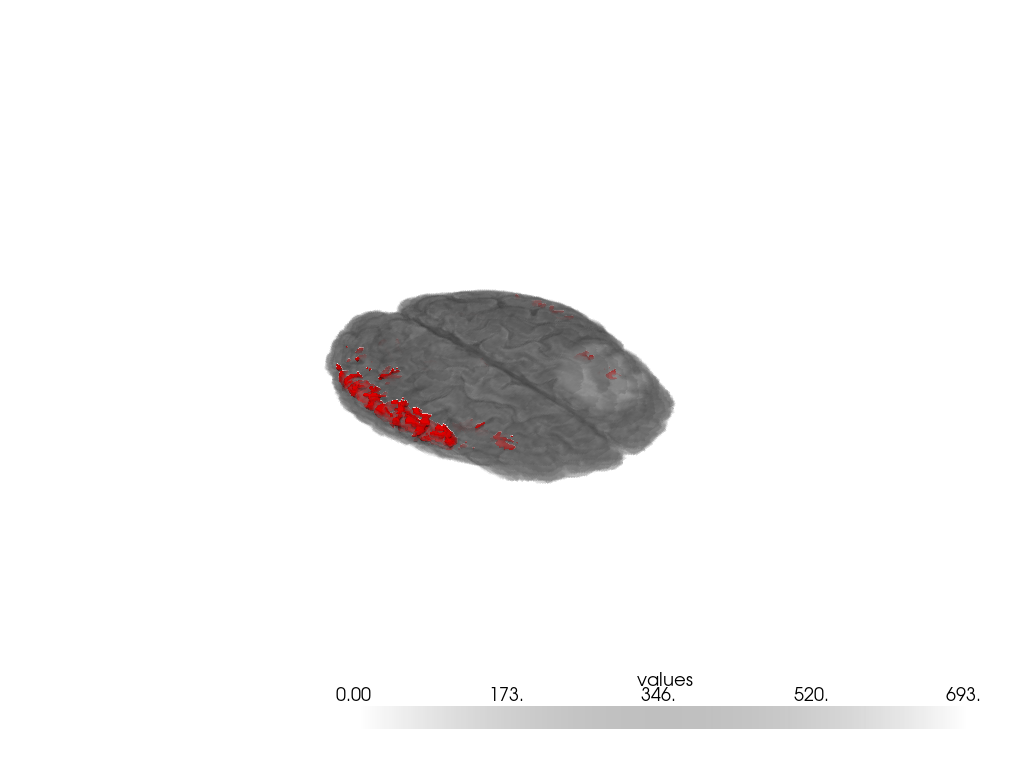

In [11]:


import pyvista as pv
import numpy as np

# img : ton volume original (D,H,W)
# pred_mask : ton masque binaire ou multi-classes (D,H,W)
img_data = nib.load("../../raw_data/segmentation/YG_01M98EKKAR50_2016-11-13_10-16-23_FLAIR.nii.gz").get_fdata().astype(np.float32)
# Créer un maillage pour l'image originale (volume rendering)
grid_img = pv.wrap(img_data.astype(np.float32))
# Créer un maillage pour le masque (isosurface)
grid_mask = pv.wrap(pred_mask.astype(np.uint8))
contour_mask = grid_mask.contour(isosurfaces=[1])  # surface de la classe 1

# Plotter
plotter = pv.Plotter()
plotter.add_volume(grid_img, cmap="gray", opacity="linear")   # rendu volumique de l'image
plotter.add_mesh(contour_mask, color="red", opacity=1)      # surface du masque
plotter.show()

In [12]:
img2 = nib.load("../../raw_data/segmentation/YG_01M98EKKAR50_2016-12-20_12-21-10_FLAIR.nii.gz").get_fdata().astype(np.float32)
img2 = (img2 - img2.mean()) / (img2.std() + 1e-6)

# Dupliquer 4 fois → shape (4, D, H, W)
img2 = np.stack([img2]*4, axis=0)

# Ajouter batch → (1, 4, D, H, W)
img_tensor2 = torch.tensor(img2[None, ...])


roi_size = (128,128,128)
sw_batch_size = 4

with torch.no_grad():
    pred2 = sliding_window_inference(img_tensor2, roi_size, sw_batch_size, model)

# Convertir en masque
pred_mask2 = torch.argmax(pred2, dim=1).cpu().numpy()[0]

/home/aurore/.pyenv/versions/brain-env/lib/python3.10/site-packages/monai/inferers/utils.py:226: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:345.)
  win_data = torch.cat([inputs[win_slice] for win_slice in unravel_slice]).to(sw_device)
/home/aurore/.pyenv/versions/brain-env/lib/python3.10/site-packages/monai/inferers/utils.py:370: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torc

/home/aurore/.pyenv/versions/brain-env/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


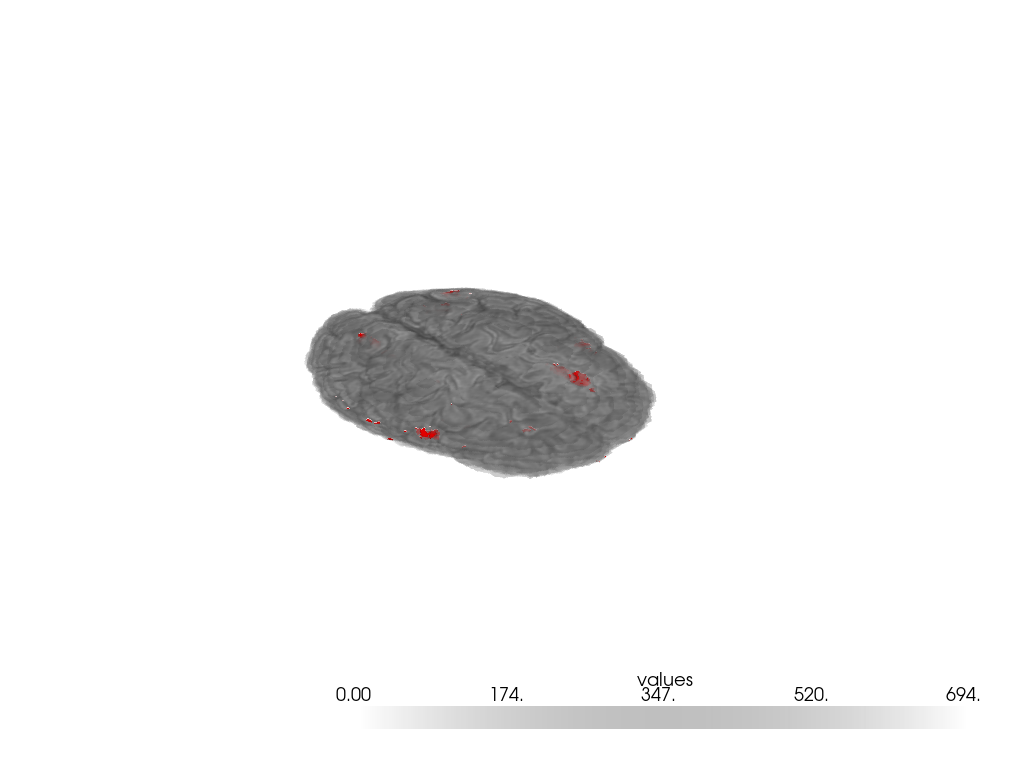

In [13]:

# img : ton volume original (D,H,W)
# pred_mask : ton masque binaire ou multi-classes (D,H,W)
img_data2 = nib.load("../../raw_data/segmentation/YG_01M98EKKAR50_2016-12-20_12-21-10_FLAIR.nii.gz").get_fdata().astype(np.float32)
# Créer un maillage pour l'image originale (volume rendering)
grid_img2 = pv.wrap(img_data2.astype(np.float32))
# Créer un maillage pour le masque (isosurface)
grid_mask2 = pv.wrap(pred_mask2.astype(np.uint8))
contour_mask2 = grid_mask2.contour(isosurfaces=[1])  # surface de la classe 1

# Plotter
plotter = pv.Plotter()
plotter.add_volume(grid_img2, cmap="gray", opacity="linear")   # rendu volumique de l'image
plotter.add_mesh(contour_mask2, color="red", opacity=1)      # surface du masque
plotter.show()

In [6]:

path_brats = "../../raw_data/segmentation/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/BraTS-GLI-00000-000/BraTS-GLI-00000-000-t2w.nii.gz"
img3 = nib.load(path_brats).get_fdata().astype(np.float32)
img3 = (img3 - img3.mean()) / (img3.std() + 1e-6)

# Dupliquer 4 fois → shape (4, D, H, W)
img3 = np.stack([img3]*4, axis=0)

# Ajouter batch → (1, 4, D, H, W)
img_tensor3 = torch.tensor(img3[None, ...])


roi_size = (128,128,128)
sw_batch_size = 4

with torch.no_grad():
    pred3 = sliding_window_inference(img_tensor3, roi_size, sw_batch_size, model)

# Convertir en masque
pred_mask3= torch.argmax(pred3, dim=1).cpu().numpy()[0]

/home/aurore/.pyenv/versions/brain-env/lib/python3.10/site-packages/monai/inferers/utils.py:226: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:345.)
  win_data = torch.cat([inputs[win_slice] for win_slice in unravel_slice]).to(sw_device)
/home/aurore/.pyenv/versions/brain-env/lib/python3.10/site-packages/monai/inferers/utils.py:370: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torc

In [7]:



path_brats_seg = "../../raw_data/segmentation/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/BraTS-GLI-00000-000/BraTS-GLI-00000-000-seg.nii.gz"
# img : ton volume original (D,H,W)
# pred_mask : ton masque binaire ou multi-classes (D,H,W)
img_data3 = nib.load(path_brats).get_fdata().astype(np.float32)
# Créer un maillage pour l'image originale (volume rendering)
grid_img3 = pv.wrap(img_data3.astype(np.float32))
# Créer un maillage pour le masque (isosurface)
grid_mask3 = pv.wrap(pred_mask3.astype(np.uint8))
contour_mask3 = grid_mask3.contour(isosurfaces=[1])  # surface de la classe 1

img_seg3 = nib.load(path_brats_seg).get_fdata().astype(np.float32)
# Créer un maillage pour l'image originale (volume rendering)
seg_img3 = pv.wrap(img_seg3.astype(np.float32))
contour_seg3 = seg_img3.contour(isosurfaces=[1])

# Plotter
plotter = pv.Plotter()
plotter.add_volume(grid_img3, cmap="gray", opacity="linear")
plotter.add_mesh(contour_seg3, color="yellow", opacity=1) # rendu volumique de l'image
plotter.add_mesh(contour_mask3, color="red", opacity=1)      # surface du masque

plotter.show(auto_close=False)

Widget(value='<iframe src="http://localhost:42155/index.html?ui=P_0x75b34ccde560_0&reconnect=auto" class="pyvi…

In [28]:
!pip install "pyvista[jupyter]"


  Using cached pyyaml-6.0.3-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (2.4 kB)
  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiosignal-1.4.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached async_timeout-5.0.1-py3-none-any.whl.metadata (5.1 kB)
  Using cached attrs-25.4.0-py3-none-any.whl.metadata (10 kB)
  Using cached widgetsnbextension-4.0.15-py3-none-any.whl.metadata (1.6 kB)
  Using cached jupyter_server-2.17.0-py3-none-any.whl.metadata (8.5 kB)
  Using cached argon2_cffi-25.1.0-py3-none-any.whl.metadata (4.1 kB)
  Using cached jupyter_events-0.12.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached jupyter_server_terminals-0.5.3-py3-none-any.whl.metadata (5.6 kB)
  Using cached nbconvert-7.16.6-py3-none-any.whl.metadata (8.5 kB)
  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
  Using cached overrides-7.7.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached prometheus_client-